In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Preprocess Data

Fraction of participants: 0.40


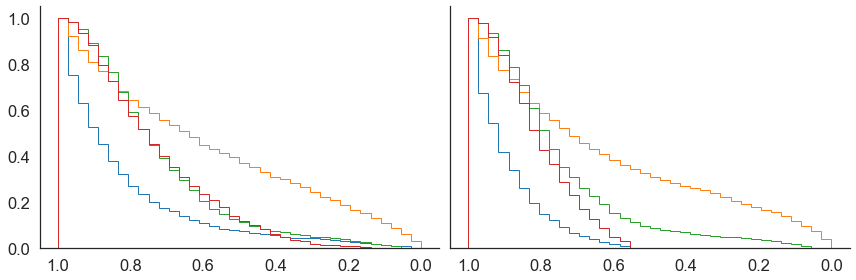

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv('data.csv').query('Study=="2018moutoussis"')

## Reduce to participants at both sessions.
data = data.groupby('Subject').filter(lambda x: x.Condition.nunique()==2)

## Compute accuracy within participants & sessions.
pre = data.groupby(['Subject','Condition','Cue']).Accuracy.mean().reset_index()
pre['Cue'] = pre.Cue.replace({1:'GW',2:'GAL',3:'NGW',4:'NGAL'})

## Compute fraction of participants with at least one bad session.
pivot = pre.pivot_table(index=('Subject','Condition'), columns='Cue', values='Accuracy')
pivot['R1'] = pivot['GW'] < 0.55
pivot['R2'] = pivot['NGAL'] < 0.55
pivot['R3'] = np.logical_or(pivot['R1'], pivot['R2'])
reject = pivot.groupby('Subject').R3.apply(lambda x: np.any(x))
print('Fraction of participants: %0.2f' %reject.mean())

## Reject participants.
data = data[~np.in1d(data.Subject, reject[reject].index)]

## Compute accuracy within participants & sessions.
post = data.groupby(['Subject','Condition','Cue']).Accuracy.mean().reset_index()
post['Cue'] = post.Cue.replace({1:'GW',2:'GAL',3:'NGW',4:'NGAL'})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
bins = np.linspace(0,1,37)

## Iteratively plot.
for ax, gb in zip(axes, [pre, post]):

    for c in ['GW','NGW','GAL','NGAL']:
        ax.hist(gb.query(f'Cue=="{c}"').Accuracy, bins=bins, density=True, cumulative=1, histtype='step')

ax.invert_xaxis()
sns.despine()
plt.tight_layout()

## Section 2: Prepare for Stan

In [3]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Filter data.
data = data.query('Condition=="Control"')
data = data[np.in1d(data.Subject, np.random.choice(data.Subject.unique(), 20, replace=False))]

## Define data.
Y = data.pivot_table('Choice','Subject','Trial').astype(int).values
X = data.pivot_table('Cue','Subject','Trial').astype(int).values
R = data.pivot_table('Outcome','Subject','Trial').astype(int).values

## Define metadata.
N, T = Y.shape

## Assemble data.
dd = dict(N=N, T=T, Y=Y, X=X, R=R)

## Secttion 3:

In [7]:
import os, pystan
from stantools.io import load_model, save_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = f'pit_4arm_m1'

## Sampling parameters.
samples = 1000
warmup = 800
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)
    
## Load StanModel
StanModel = load_model(os.path.join('stan_models','base',stan_model))

## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, 
                             thin=thin, n_jobs=n_jobs, seed=0)

## Save.
# save_fit(f, StanFit, data=dd)

In [8]:
print(StanFit)

Inference for Stan model: anon_model_d2b632c9a5fcd096c5781cc35a66ead8.
4 chains, each with iter=1000; warmup=800; thin=1; 
post-warmup draws per chain=200, total post-warmup draws=800.

              mean se_mean     sd    2.5%     25%    50%     75%   97.5%  n_eff   Rhat
rho_pr[1]     0.75    0.03   0.62   -0.33    0.31   0.68    1.14    2.15    470    1.0
rho_pr[2]     0.57    0.03   0.63   -0.41    0.13   0.48    0.93    2.05    625    1.0
rho_pr[3]    -0.79    0.02   0.34   -1.28   -0.99  -0.83   -0.63   -0.08    257   1.01
rho_pr[4]     0.46    0.03   0.75   -0.69   -0.09   0.35     0.9    2.19    532    1.0
rho_pr[5]     0.06    0.05   0.81   -1.06   -0.61  -0.07     0.6    1.91    262   1.01
rho_pr[6]     0.82    0.03   0.73   -0.45     0.3    0.8    1.27    2.39    693    1.0
rho_pr[7]     1.04    0.03   0.73   -0.46    0.62   1.03    1.48    2.56    440    1.0
rho_pr[8]     0.25    0.03   0.61   -0.67   -0.17   0.14    0.57    1.78    375    1.0
rho_pr[9]     1.22    0.03   0.